In [21]:
from pathlib import Path

Path.cwd()

import logging
import pickle
import os
import random
import shutil
import time

import numpy as np
import torch
from attrdict import AttrDict

from sklearn.model_selection import train_test_split

from timegan.models import TimeGAN
from timegan.models.utils import timegan_trainer, timegan_generator
from timegan.data.data_preprocess import data_preprocess

In [67]:
args = AttrDict(
    seed=1,
    exp="test",
    is_train=True,
    feat_pred_no=2,
    max_seq_len=7,
    train_rate=0.5,
    emb_epochs=100,
    sup_epochs=100,
    gan_epochs=100,
    batch_size=128,
    hidden_dim=20,
    num_layers=3,
    dis_thresh=0.15,
    optimizer="adam",
    learning_rate=1e-3,
    device="cpu"
)

In [68]:
args.model_path = os.path.abspath(f"./output/{args.exp}/")
out_dir = os.path.abspath(args.model_path)
if not os.path.exists(out_dir):
    os.makedirs(out_dir, exist_ok=True)

tensorboard_path = os.path.abspath("./tensorboard")
if not os.path.exists(tensorboard_path):
    os.makedirs(tensorboard_path, exist_ok=True)

In [69]:

random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)

data_path = Path.cwd() / "timegan" / "data/stock.csv"

X, T, _, args.max_seq_len, args.padding_value = data_preprocess(
    data_path, args.max_seq_len
)

args.feature_dim = X.shape[-1]
args.Z_dim = X.shape[-1]

Loading data...

Dropped 504 rows (outliers)



100%|██████████| 3676/3676 [00:14<00:00, 254.67it/s]


In [70]:
from pprint import pprint

pprint(args)

{'Z_dim': 6,
 'batch_size': 128,
 'device': 'cpu',
 'dis_thresh': 0.15,
 'emb_epochs': 100,
 'exp': 'test',
 'feat_pred_no': 2,
 'feature_dim': 6,
 'gan_epochs': 100,
 'hidden_dim': 20,
 'is_train': True,
 'learning_rate': 0.001,
 'max_seq_len': 7,
 'model_path': '/mnt/c/Users/s2216495/Desktop/demand/swedes/output/test',
 'num_layers': 3,
 'optimizer': 'adam',
 'padding_value': -1.0,
 'seed': 1,
 'sup_epochs': 100,
 'train_rate': 0.5}


In [71]:
# Train-Test Split data and time
train_data, test_data, train_time, test_time = train_test_split(
    X, T, test_size=args.train_rate, random_state=args.seed
)

In [72]:
model = TimeGAN(args)
if args.is_train:
    timegan_trainer(model, train_data, train_time, args)

generated_data = timegan_generator(model, train_time, args)
generated_time = train_time


Start Embedding Network Training


Epoch: 99, Loss: 0.0153: 100%|██████████| 100/100 [02:05<00:00,  1.25s/it]



Start Training with Supervised Loss Only


Epoch: 99, Loss: 0.0656: 100%|██████████| 100/100 [01:03<00:00,  1.57it/s]



Start Joint Training


Epoch: 99, E: 0.3640, G: 4.7951, D: 1.0528: 100%|██████████| 100/100 [17:43<00:00, 10.64s/it]



Saved at path: /mnt/c/Users/s2216495/Desktop/demand/swedes/output/test

Generating Data...


(1838, 7, 6)
(1838, 7, 6)


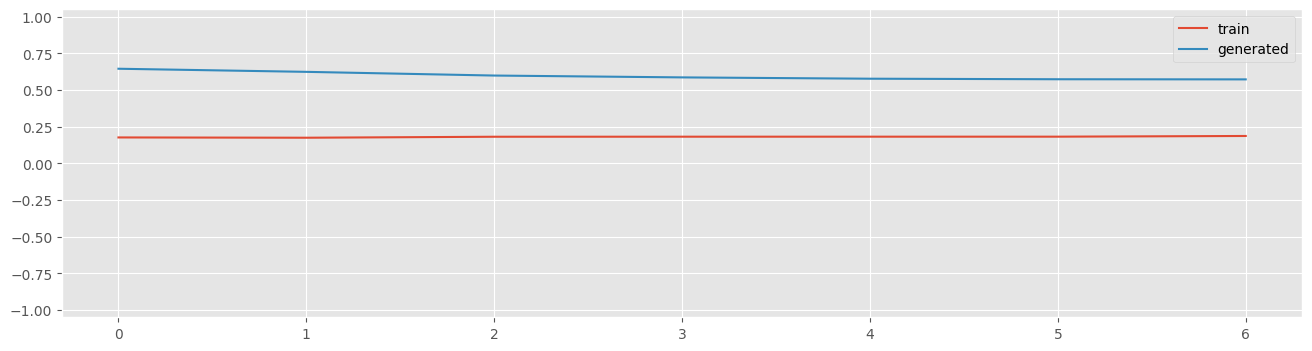

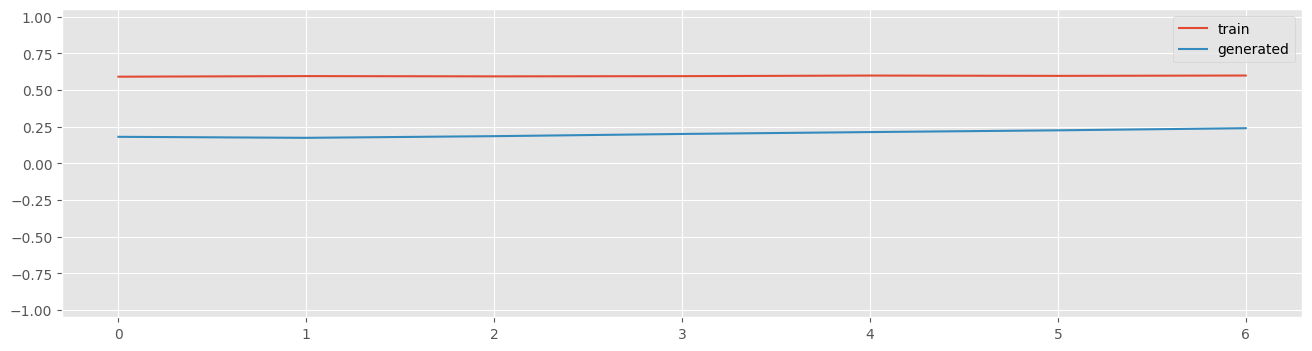

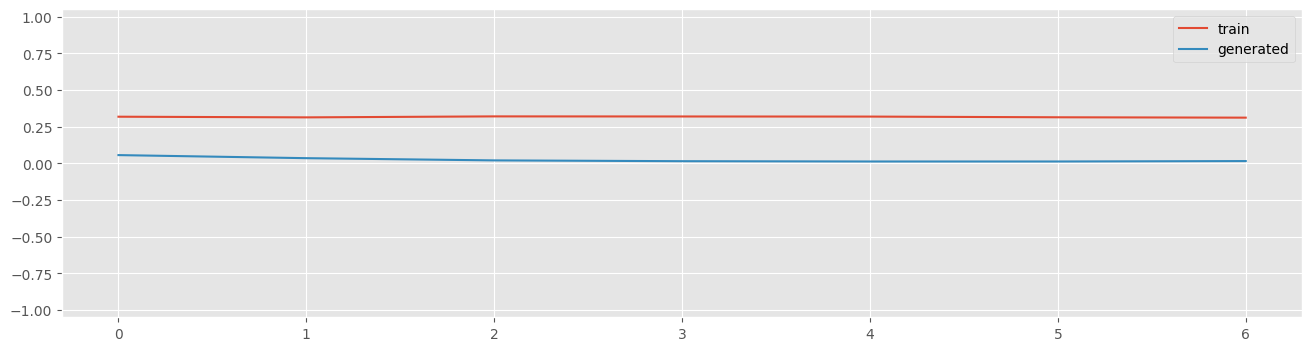

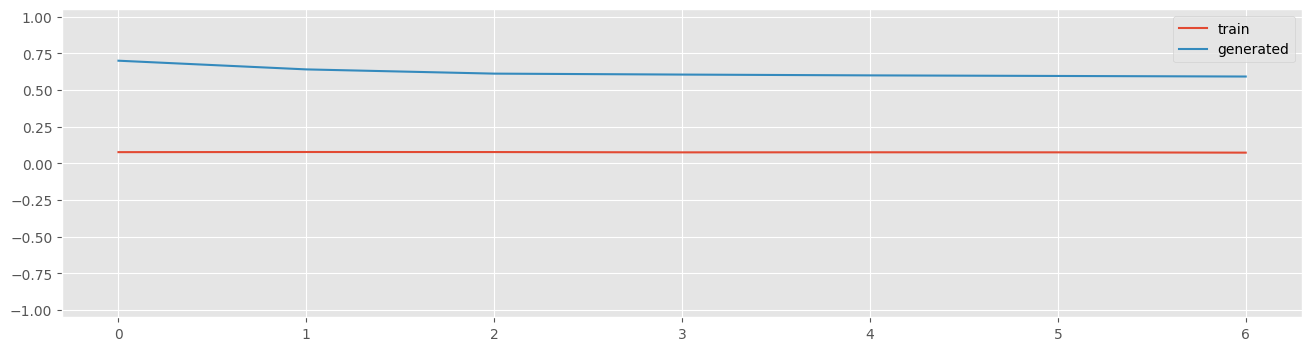

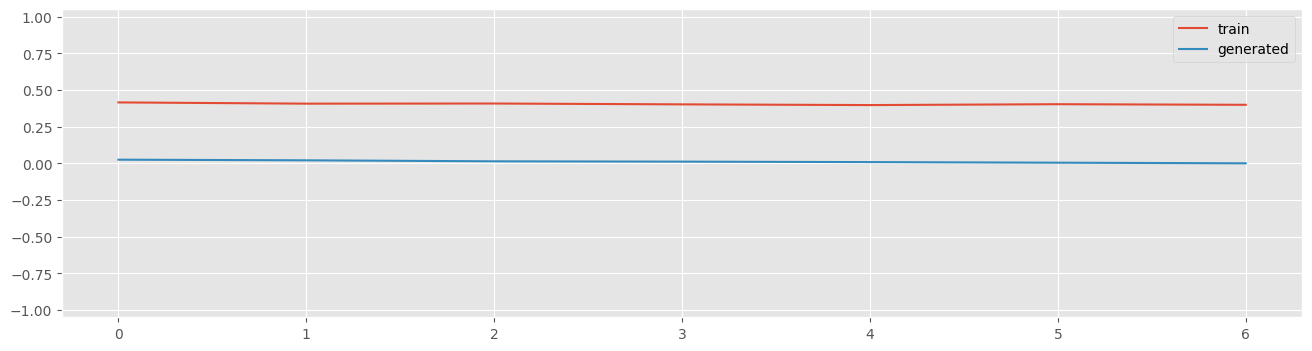

In [76]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

print(generated_data.shape)
print(train_data.shape)

n = args.max_seq_len
x = np.arange(n)

for _ in range(5):
    fig, ax = plt.subplots(1, 1, figsize=(16, 4))

    sample = np.random.choice(np.arange(train_data.shape[0]).tolist())

    ax.plot(x, train_data[sample, :, 0], label="train")
    ax.plot(x, generated_data[sample, :, 0], label="generated")

    ax.legend()
    ax.set_ylim(-1.05, 1.05)
    plt.show()

In [52]:
data_path = Path.cwd() / "timegan" / "data/stock.csv"

X, T, _, args.max_seq_len, args.padding_value = data_preprocess(
    data_path, args.max_seq_len
)

Loading data...

Dropped 504 rows (outliers)



100%|██████████| 3676/3676 [00:13<00:00, 268.25it/s]


0       7
2443    7
2445    7
2446    7
2447    7
       ..
1229    7
1230    7
1231    7
1232    7
3677    7
Name: Idx, Length: 3678, dtype: int64
   Idx      Open      High       Low     Close  Adj_Close    Volume
0    0  0.193767  0.194468  0.197752  0.195663   0.195663  0.061479
1    0  0.192324  0.192243  0.195193  0.193290   0.193290  0.064805
2    0  0.195943  0.194814  0.194233  0.191215   0.191215  0.146998
3    0  0.200789  0.200194  0.201437  0.198794   0.198794  0.049875
4    0  0.199065  0.200377  0.203777  0.200473   0.200473  0.063465
5    0  0.196723  0.197522  0.200874  0.198418   0.198418  0.049265
6    0  0.197284  0.196442  0.200395  0.196413   0.196413  0.034498
7    1  0.486096  0.496400  0.495676  0.494497   0.494497  0.021747
8    1  0.485228  0.488788  0.492230  0.489877   0.489877  0.015313
9    1  0.483517  0.486737  0.489156  0.487366   0.487366  0.019826
(25746, 7)
(3676, 100, 6)
3676
[7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 

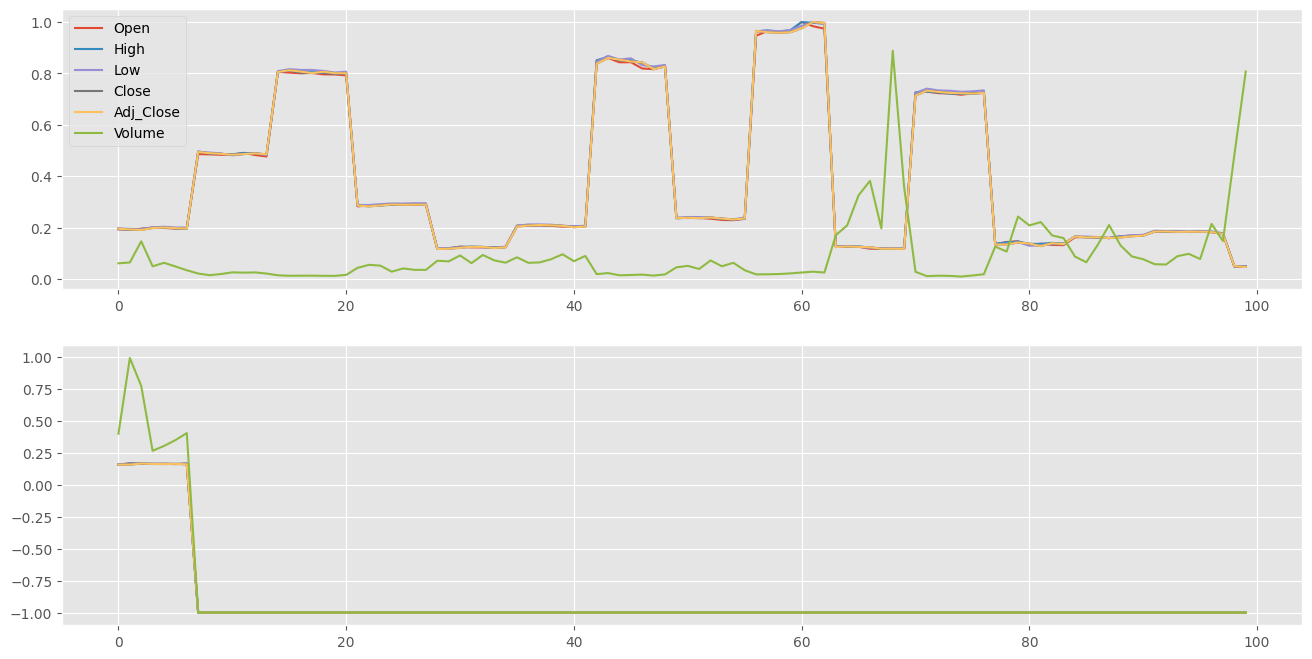

In [66]:
df = pd.read_csv(data_path).drop(columns="Unnamed: 0")

print(df.Idx.value_counts())

print(df.head(10))
print(df.shape)
print(X.shape)
print(len(T))
print(T[:50])
print(args.max_seq_len)

steps = 100
x = np.arange(steps)

fig, axs = plt.subplots(2, 1, figsize=(16, 8))

df.iloc[:7].drop(columns="Idx").plot(ax=axs[0])
axs[1].plot(x, X[-1])

plt.show()